In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/local/openjdk-8"
os.environ["SPARK_HOME"] = "/user_data/spark-3.3.0-bin-hadoop2"

import findspark
findspark.init('spark-3.3.0-bin-hadoop2')

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("ac2")
    .config("spark.sql.warehouse.dir", "hdfs:///user/hive/warehouse")
    .config("spark.sql.catalogImplementation", "hive")
    .getOrCreate()
)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/user_data/spark-3.3.0-bin-hadoop2/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/hadoop-2.7.3/share/hadoop/common/lib/slf4j-log4j12-1.7.10.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/04/27 15:04:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataframe = spark.read.csv("hdfs://spark-master:9000/datasets/flight/Combined_Flights_2022.csv", header=True, inferSchema=True)
use_cols = [
    'Month',
    'Origin',
     'Dest',
     'Cancelled',
     'Diverted',
     'CRSDepTime',
     'DepTime',
     'DepDelayMinutes', 
    'Marketing_Airline_Network',
    'ArrDelayMinutes',
    'DayOfWeek',
    'TaxiIn',
    'TaxiOut',
    'Distance'
]

dataframe = dataframe.select(*use_cols)
lines_count = dataframe.count()
print(f"Número de linhas no DataFrame: {lines_count}")

Número de linhas no DataFrame: 4078318


In [4]:
dataframe.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Distance: double (nullable = true)



In [5]:
dataframe.describe().show()

+-------+------------------+-------+-------+------------------+------------------+------------------+-------------------------+------------------+-----------------+-----------------+------------------+-----------------+
|summary|             Month| Origin|   Dest|        CRSDepTime|           DepTime|   DepDelayMinutes|Marketing_Airline_Network|   ArrDelayMinutes|        DayOfWeek|           TaxiIn|           TaxiOut|         Distance|
+-------+------------------+-------+-------+------------------+------------------+------------------+-------------------------+------------------+-----------------+-----------------+------------------+-----------------+
|  count|           4078318|4078318|4078318|           4078318|           3957885|           3957823|                  4078318|           3944916|          4078318|          3954076|           3955652|          4078318|
|   mean| 4.083803420920095|   null|   null|1329.5866648946944|1334.3739312789533|16.014938010113134|                   

In [6]:
dataframe.show(5)

+-----+------+----+---------+--------+----------+-------+---------------+-------------------------+---------------+---------+------+-------+--------+
|Month|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|Marketing_Airline_Network|ArrDelayMinutes|DayOfWeek|TaxiIn|TaxiOut|Distance|
+-----+------+----+---------+--------+----------+-------+---------------+-------------------------+---------------+---------+------+-------+--------+
|    4|   GJT| DEN|    false|   false|      1133| 1123.0|            0.0|                       UA|            0.0|        1|   8.0|   17.0|   212.0|
|    4|   HRL| IAH|    false|   false|       732|  728.0|            0.0|                       UA|            0.0|        1|   9.0|   16.0|   295.0|
|    4|   DRO| DEN|    false|   false|      1529| 1514.0|            0.0|                       UA|            0.0|        1|  14.0|   21.0|   251.0|
|    4|   IAH| GPT|    false|   false|      1435| 1430.0|            0.0|                       UA| 

- Analisando os voos cancelados, foi observado que 3% da base de dados foram cancelados.
- O mês de janeiro (1) apresentou a maior quantidade de voos cancelados, em seguida de fevereiro (2) e junho (6)
- A companhia áerea AA, seguida da UA e DL apresentaram maior quantidades de voos cancelados.

In [7]:
# Proporção de voos cancelados
cancelled_ratio = (
    dataframe.select(
        F.count(
            F.when(
                F.col("Cancelled") == 1, 1
            )
        )
    ).collect()[0][0] / dataframe.count()
) * 100

print(f"Proporção de Voos Cancelados: {cancelled_ratio:.2f}%")

# Distribuição de voos cancelados por mês
df_cancelado_por_mes = dataframe.groupBy("Month").agg(
    F.count(
        F.when(
            F.col("Cancelled") == 1, 1
        )
    ).alias("Voos cancelados")
).orderBy("Month")
df_cancelado_por_mes.show()

# Distribuição de voos cancelados por companhia aérea
cancelled_by_network = dataframe.groupBy("Marketing_Airline_Network").agg(
    F.count(
        F.when(
            F.col("Cancelled") == 1, 1
        )
    ).alias("Voos cancelados")
).orderBy("Voos cancelados")
cancelled_by_network.show()

Proporção de Voos Cancelados: 3.02%


+-----+---------------+
|Month|Voos cancelados|
+-----+---------------+
|    1|          35667|
|    2|          23421|
|    3|           9108|
|    4|          13397|
|    5|          11993|
|    6|          18473|
|    7|          11133|
+-----+---------------+



+-------------------------+---------------+
|Marketing_Airline_Network|Voos cancelados|
+-------------------------+---------------+
|                       HA|            351|
|                       F9|           2501|
|                       G4|           2891|
|                       NK|           4198|
|                       AS|           5016|
|                       B6|           7631|
|                       WN|          18164|
|                       DL|          20969|
|                       UA|          24705|
|                       AA|          36766|
+-------------------------+---------------+



Como o número de células vazias no nosso dataset é de cerca de 3%, o que é uma quantidade baixa, iremos apenas eliminar esses dados, ao invés de tratarmos. 
Uma observação é que uma boa parte desses valores nulos encontrados nas colunas, percentem a vôos cancelados, como o tempo de atraso, que são nulos por conta da viagem não ter ocorrido. Como iremos focar na previsão do tempo de atraso e não na previsão de dados cancelados, iremos remover essa porcentagem de valores nulos. 
Vale lembrar que se o foco fosse na previsão de vôos cancelados, a base iria estar bem desequilibrada, por conta de ter apenas 3% de cancelamentos para treinar o modelo de predição, em que deveriamos considerar outra base de dados, ou até mesmo preencher os valores nulos, o que resultaria em predições viciadas dada a proporção.

In [8]:
total_count = dataframe.count()
not_null_count = dataframe.dropna().count() 
percentage_not_null = not_null_count * 100 / total_count
print(f"Porcentagem não nula: {percentage_not_null}")
dataframe = dataframe.dropna()

Porcentagem não nula: 96.72899464926472


Ao analisar a correlação entre os dados, é possível notar que o atraso na chegada, é fortemente influenciado pelo atraso na partida. Logo, um atraso na partida tem boa probabilidade de resultar um atraso na chegada.

24/04/27 15:05:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/27 15:05:37 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


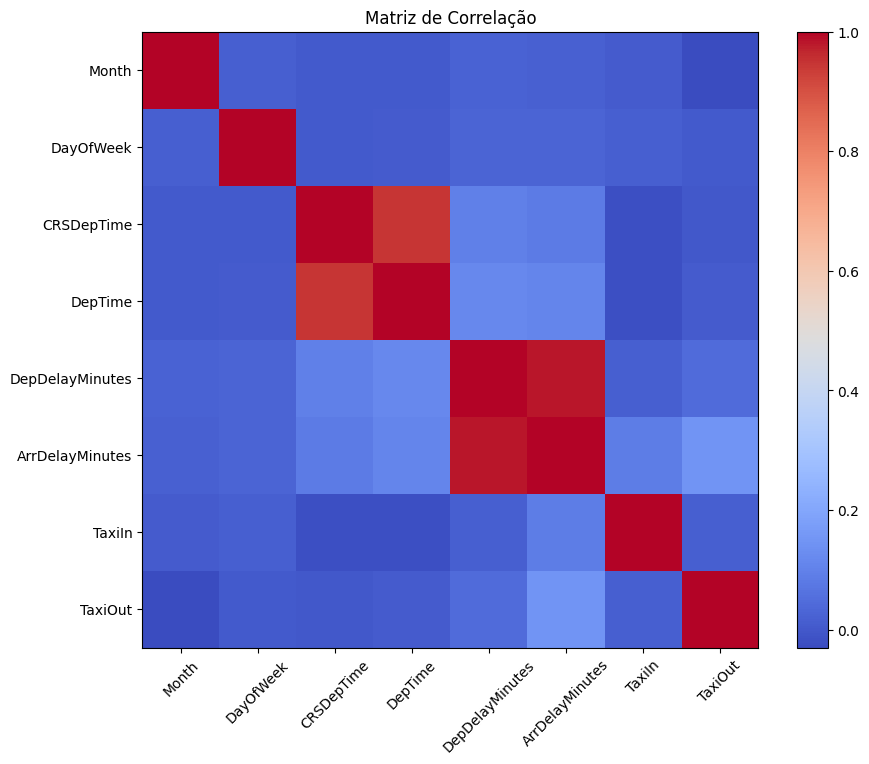

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Selecionando as colunas relevantes para a matriz de correlação
feature_columns = [
    "Month",
    "DayOfWeek",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "ArrDelayMinutes",
    'TaxiIn',
    'TaxiOut'
]

# Montando as features em um único vetor
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(dataframe)

# Calculando a matriz de correlação
correlation_matrix = Correlation.corr(assembled_data, "features").head()

# Extraindo a matriz de correlação
corr_matrix = correlation_matrix[0].toArray()

# Plotando o mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(feature_columns)), feature_columns, rotation=45)
plt.yticks(range(len(feature_columns)), feature_columns)
plt.title("Matriz de Correlação")
plt.show()


- Analisando o tempo de atraso, foi observado uma média de 15 minutos de atraso.
- O mês de julho (7) e junho (6) apresentaram um tempo médio de atraso maior
- As companias B6, G4 e F9 apresentaram maior tempo de atraso médio

In [10]:
# Tempo médio de atraso (minutos)
average_delay = dataframe.select(F.avg("ArrDelayMinutes")).collect()[0][0]
print(f"Tempo Médio de Atraso: {average_delay:.2f} minutos")

# Distribuição de atrasos por mês
delay_by_month = dataframe.groupBy("Month").agg(F.avg("ArrDelayMinutes").alias("atraso_medio")).orderBy("Month")
delay_by_month.show()

# Distribuição de atrasos por companhia aérea
delay_by_company = dataframe.groupBy("Marketing_Airline_Network").agg(F.avg("ArrDelayMinutes").alias("atraso_medio")).orderBy("atraso_medio", ascending=False)
delay_by_company.show()

Tempo Médio de Atraso: 15.78 minutos


+-----+------------------+
|Month|      atraso_medio|
+-----+------------------+
|    1|14.354921483258492|
|    2| 14.22176289364896|
|    3|15.282290116612899|
|    4|15.949220248947393|
|    5|15.079478974372895|
|    6|17.849852879505566|
|    7|17.326682130740213|
+-----+------------------+



+-------------------------+------------------+
|Marketing_Airline_Network|      atraso_medio|
+-------------------------+------------------+
|                       B6| 28.37808613922048|
|                       G4| 25.35006813149378|
|                       F9| 23.98092831430138|
|                       NK|19.172122475152293|
|                       AA|16.423352661730473|
|                       UA|16.016196415089063|
|                       WN|13.865528202334586|
|                       DL| 13.74481651165211|
|                       AS|10.575677971939655|
|                       HA|  9.06934315296143|
+-------------------------+------------------+



Na contagem de atrasos, é possível ver que a maioria dos atrasos foram atrasos curtos, o que diminui proporcionalmente com o aumento do tempo observado

In [11]:
# Apresenta a contagem de atrasos a cada range de 10 minutos
dataframe.groupBy("ArrDelayMinutes").agg(F.count("*").alias("count")).orderBy("ArrDelayMinutes").withColumn("bin", F.floor(F.col("ArrDelayMinutes") / 10)).groupBy("bin").agg(F.sum("count").alias("count")).sort("bin").withColumn("delay_range", F.concat(F.col("bin") * 10, F.lit(" - "), F.col("bin") * 10 + 9)).show(truncate=False)

+---+-------+-----------+
|bin|count  |delay_range|
+---+-------+-----------+
|0  |2925045|0 - 9      |
|1  |291309 |10 - 19    |
|2  |175819 |20 - 29    |
|3  |116959 |30 - 39    |
|4  |82921  |40 - 49    |
|5  |61855  |50 - 59    |
|6  |47347  |60 - 69    |
|7  |38017  |70 - 79    |
|8  |30520  |80 - 89    |
|9  |25074  |90 - 99    |
|10 |20470  |100 - 109  |
|11 |17396  |110 - 119  |
|12 |14637  |120 - 129  |
|13 |12361  |130 - 139  |
|14 |10528  |140 - 149  |
|15 |8925   |150 - 159  |
|16 |7603   |160 - 169  |
|17 |6482   |170 - 179  |
|18 |5555   |180 - 189  |
|19 |4936   |190 - 199  |
+---+-------+-----------+
only showing top 20 rows



Ao apresentar os dados de atraso na chegada, é possível ver, conforme demonstrado anteriormente no `describe`, que há valores altos de atraso com uma frequência bem baixa, chegando a 7000 minutos de atraso, enquanto a maioria está concentrada na faixa de 30 minutos de atraso.

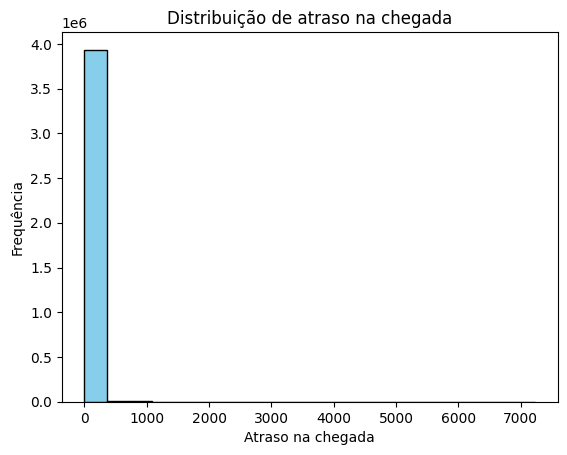

In [12]:
arr_delay_values = dataframe.select("ArrDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.hist(arr_delay_values, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Atraso na chegada")
plt.ylabel("Frequência")
plt.title("Distribuição de atraso na chegada")
plt.show()

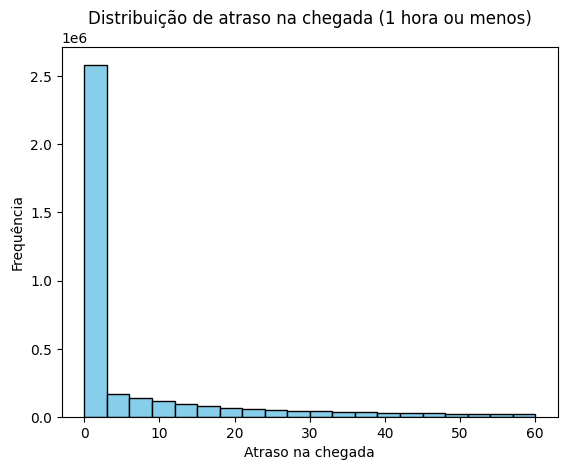

In [13]:
filtered_dataframe = dataframe.where(dataframe["ArrDelayMinutes"] < 61)
arr_delay_values = filtered_dataframe.select("ArrDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.hist(arr_delay_values, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Atraso na chegada")
plt.ylabel("Frequência")
plt.title("Distribuição de atraso na chegada (1 hora ou menos)")
plt.show()

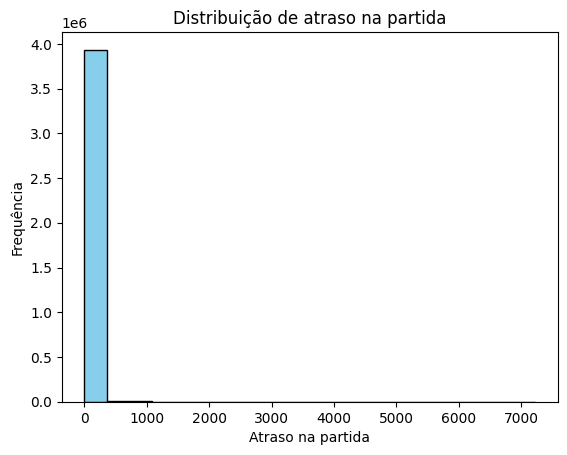

In [14]:
arr_delay_values = dataframe.select("DepDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.hist(arr_delay_values, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Atraso na partida")
plt.ylabel("Frequência")
plt.title("Distribuição de atraso na partida")
plt.show()

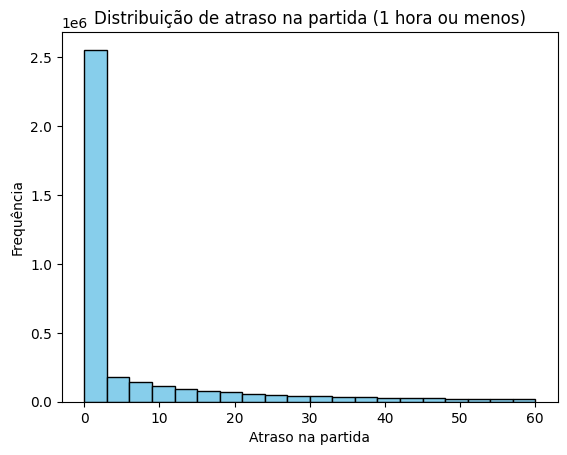

In [15]:
filtered_dataframe = dataframe.where(dataframe["DepDelayMinutes"] < 61)
arr_delay_values = filtered_dataframe.select("DepDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.hist(arr_delay_values, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Atraso na partida")
plt.ylabel("Frequência")
plt.title("Distribuição de atraso na partida (1 hora ou menos)")
plt.show()

In [16]:
# Group delays by DayOfWeek
delay_by_day = dataframe.groupBy("DayOfWeek").agg(F.avg("ArrDelayMinutes").alias("avg_delay")).orderBy("DayOfWeek")
print("\n Atraso medio por dia da semana:")
delay_by_day.show()


 Atraso medio por dia da semana:


+---------+------------------+
|DayOfWeek|         avg_delay|
+---------+------------------+
|        1| 15.74601072509473|
|        2|11.869317071120992|
|        3|12.726657243841833|
|        4|16.852069657735345|
|        5|18.470271691679443|
|        6| 17.33519092649646|
|        7| 17.26704135159071|
+---------+------------------+



Verificando se o tempo no atraso da entrada do taxi influencia o tempo de atraso da partida, o que não influencia tanto para um atraso alto, mas apresenta uma quantidade de atrasos também.

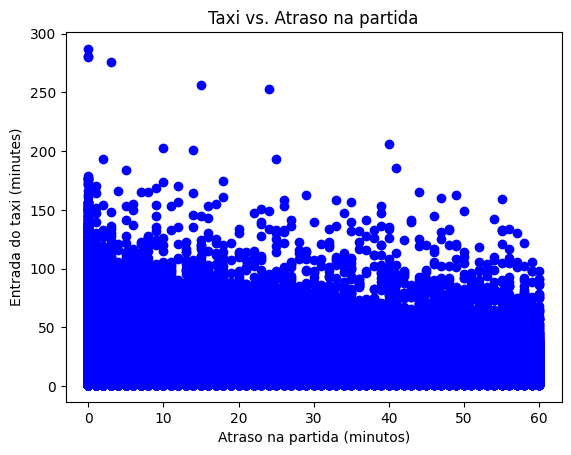

In [17]:
filtered_dataframe = dataframe.where(dataframe["DepDelayMinutes"] < 61)
arr_taxi_in_values = filtered_dataframe.select("TaxiIn").rdd.flatMap(lambda x: x).collect()
arr_delay_values = filtered_dataframe.select("DepDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.scatter(arr_delay_values, arr_taxi_in_values, color="blue", marker="o")
plt.xlabel("Atraso na partida (minutos)")
plt.ylabel("Entrada do taxi (minutes)")
plt.title("Taxi vs. Atraso na partida")
plt.show()

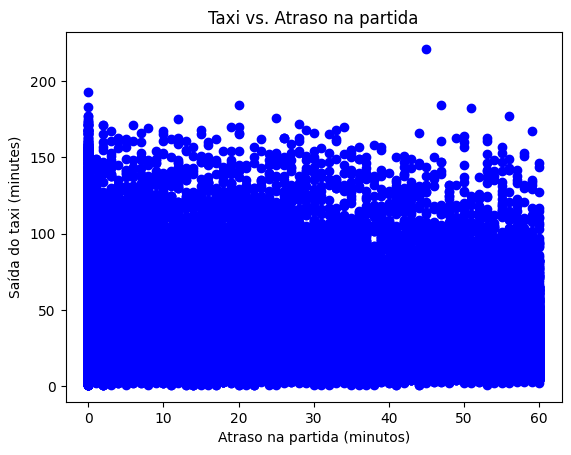

In [18]:
arr_taxi_in_values = filtered_dataframe.select("TaxiOut").rdd.flatMap(lambda x: x).collect()
arr_delay_values = filtered_dataframe.select("DepDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.scatter(arr_delay_values, arr_taxi_in_values, color="blue", marker="o")
plt.xlabel("Atraso na partida (minutos)")
plt.ylabel("Saída do taxi (minutes)")
plt.title("Taxi vs. Atraso na partida")
plt.show()

O mesmo foi feito para a distância, o que também apresenta que uma distância alta não significa um atraso proporcionalmente alto.

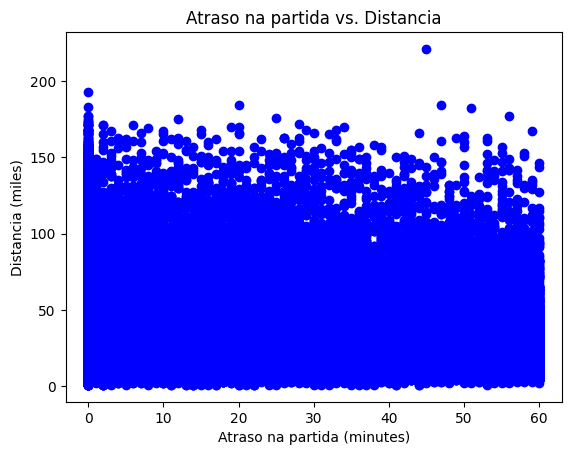

In [19]:
arr_distance_values = filtered_dataframe.select("Distance").rdd.flatMap(lambda x: x).collect()
arr_delay_values = filtered_dataframe.select("DepDelayMinutes").rdd.flatMap(lambda x: x).collect()
plt.scatter(arr_delay_values, arr_taxi_in_values, color="blue", marker="o")
plt.xlabel("Atraso na partida (minutes)")
plt.ylabel("Distancia (miles)")
plt.title("Atraso na partida vs. Distancia")
plt.show()

# Pré processamento

Como a porcentagem de atrasos maiores que 1 hora é de cerca de 10%, iremos remover esses outliers que apresentam valores de atraso descrepantes.

In [20]:
filtered_dataframe = dataframe.where(dataframe["DepDelayMinutes"] < 61)
dataframe_without_outliers = filtered_dataframe.count() * 100 / dataframe.count()
print(f"Porcentagem de dados com atraso de chegada menor ou igual a 1 hora: {dataframe_without_outliers}%")

Porcentagem de dados com atraso de chegada menor ou igual a 1 hora: 92.6843816192791%


In [21]:
target = "ArrDelayMinutes"
columns_to_remove = [target, "Marketing_Airline_Network", "Origin", "Dest"]
feature_columns = filtered_dataframe.columns
for column in columns_to_remove:
  feature_columns.remove(column)

vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = vector_assembler.transform(filtered_dataframe)

In [22]:
# todo: processar mais os dados caso necessário

In [23]:
# Dividindo o conjunto de dados entre treino e teste
train_data, test_data = df_vector.randomSplit(
    [0.8, 0.2], # 80% treino e 20% teste
    seed=42 # Semente de aleatoriedade
)

# Modelagem

In [24]:
# todo: precisa ajustar a modelagem, lembrando de adicionar 2 tipos diferentes de modelos de predição para prever o tempo de atraso. 
# Usar modelo de regressao

In [27]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Criando o modelo de regressão linear
lr_model = LinearRegression(featuresCol="features", labelCol="ArrDelayMinutes")
lr_fit = lr_model.fit(train_data)

# Fazendo previsões no conjunto de teste
predictions = lr_fit.transform(test_data)

# Avaliando o desempenho do modelo
evaluator = RegressionEvaluator(labelCol="ArrDelayMinutes", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Erro médio quadrático (RMSE): {rmse:.2f}")

# Avaliando o desempenho do modelo
evaluator_r2 = RegressionEvaluator(labelCol="ArrDelayMinutes", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

evaluator_mae = RegressionEvaluator(labelCol="ArrDelayMinutes", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")

# Erro Percentual Absoluto Médio (MAPE)
mape = (predictions
        .withColumn("abs_error", F.abs(F.col("ArrDelayMinutes") - F.col("prediction")))
        .withColumn("pct_error", F.col("abs_error") / F.col("ArrDelayMinutes"))
        .agg(F.avg("pct_error"))
        .collect()[0][0])
print(f"Erro Percentual Absoluto Médio (MAPE): {mape * 100:.2f}%")


24/04/27 15:11:35 WARN Instrumentation: [8012c696] regParam is zero, which might cause numerical instability and overfitting.


24/04/27 15:11:45 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/04/27 15:11:45 WARN Instrumentation: [8012c696] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Erro médio quadrático (RMSE): 6.84


Coeficiente de Determinação (R²): 0.74


Erro Absoluto Médio (MAE): 4.50


Erro Percentual Absoluto Médio (MAPE): 91.63%


In [28]:
from pyspark.ml.regression import RandomForestRegressor

# Criando o modelo de regressão usando Random Forest
rf_model = RandomForestRegressor(featuresCol="features", labelCol="ArrDelayMinutes", numTrees=10)
rf_fit = rf_model.fit(train_data)

# Fazendo previsões no conjunto de teste
predictions_rf = rf_fit.transform(test_data)

# Avaliando o desempenho do modelo com RMSE
rmse_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest - Erro médio quadrático (RMSE): {rmse_rf:.2f}")

# Avaliando o desempenho do modelo com R²
r2_rf = evaluator_r2.evaluate(predictions_rf)
print(f"Random Forest - Coeficiente de Determinação (R²): {r2_rf:.2f}")

# Avaliando o desempenho do modelo com MAE
mae_rf = evaluator_mae.evaluate(predictions_rf)
print(f"Random Forest - Erro Absoluto Médio (MAE): {mae_rf:.2f}")

# Calculando o MAPE
mape_rf = (predictions_rf
            .withColumn("abs_error", F.abs(F.col("ArrDelayMinutes") - F.col("prediction")))
            .withColumn("pct_error", F.col("abs_error") / F.col("ArrDelayMinutes"))
            .agg(F.avg("pct_error"))
            .collect()[0][0])
print(f"Random Forest - Erro Percentual Absoluto Médio (MAPE): {mape_rf * 100:.2f}%")


24/04/27 15:12:54 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:54 WARN MemoryStore: Not enough space to cache rdd_302_12 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:54 WARN BlockManager: Persisting block rdd_302_12 to disk instead.
24/04/27 15:12:54 WARN BlockManager: Persisting block rdd_302_11 to disk instead.
24/04/27 15:12:54 WARN MemoryStore: Not enough space to cache rdd_302_2 in memory! (computed 8.0 MiB so far)
24/04/27 15:12:54 WARN BlockManager: Persisting block rdd_302_2 to disk instead.
24/04/27 15:12:54 WARN MemoryStore: Not enough space to cache rdd_302_6 in memory! (computed 8.0 MiB so far)
24/04/27 15:12:54 WARN MemoryStore: Not enough space to cache rdd_302_9 in memory! (computed 3.5 MiB so far)
24/04/27 15:12:54 WARN BlockManager: Persisting block rdd_302_6 to disk instead.
24/04/27 15:12:54 WARN BlockManager: Persisting block rdd_302_9 to disk instead.
24/04/27 15:12:54 WARN MemoryStore: Not enou

24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_3 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_9 in memory! (computed 12.6 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_4 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_2 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_15 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_8 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_14 in memory! (computed 18.9 MiB so far)
24/04/27 15:12:58 WARN MemoryStore: Not enough space to cache rdd_302_6 in memory! (computed 18.9 MiB so far)
24/04/2

24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_6 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_10 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_5 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_15 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:00 WARN MemoryStore: Not enough space to cache rdd_302_13 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:01 WARN MemoryStore: Not enough space to cache rdd_302_2 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:01 WARN MemoryStore: Not enough space to cache rdd_302_12 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:01 WARN MemoryStore: Not enough space to cache rdd_302_14 in memory! (computed 18.9 MiB so far)
24/0

24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_6 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_5 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_12 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_9 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_4 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_1 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_2 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:03 WARN MemoryStore: Not enough space to cache rdd_302_8 in memory! (computed 18.9 MiB so far)
24/04/27

24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_10 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_1 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_12 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_6 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_9 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_8 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_4 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:05 WARN MemoryStore: Not enough space to cache rdd_302_14 in memory! (computed 18.9 MiB so far)
24/04/

24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_4 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_5 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_9 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_8 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_15 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_2 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_7 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_13 in memory! (computed 18.9 MiB so far)
24/04/27 15:13:08 WARN MemoryStore: Not enough space to cache rdd_302_11 in memory! (computed 18.9 MiB so far)
24/04/2

Random Forest - Erro médio quadrático (RMSE): 7.54


Random Forest - Coeficiente de Determinação (R²): 0.69


Random Forest - Erro Absoluto Médio (MAE): 4.14


Random Forest - Erro Percentual Absoluto Médio (MAPE): 69.49%
